In [1]:
# just importing a random selection of things; we can fix this later
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.grid_search import GridSearchCV

from pprint import pprint 

from sklearn.ensemble import BaggingClassifier
from sklearn import model_selection
from random import seed
from sklearn.model_selection import cross_val_predict

from sklearn.ensemble import RandomForestClassifier
from itertools import product
from collections import OrderedDict
from itertools import product

from sklearn import model_selection
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split
from __future__ import print_function # For Python 2 / 3 compatability
from sklearn.metrics import confusion_matrix
import itertools

import warnings
from sklearn import preprocessing
%autosave 300
warnings.filterwarnings("ignore")

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Autosaving every 300 seconds


<font color = magenta> 
# 112617 MODELS

In [2]:
with open("ADNI2_clean_remove_all_missing.json") as json_file: 
    ADNI2_clean_remove_all_missing_load = pd.read_json(path_or_buf='ADNI2_clean_remove_all_missing.json')

## Logistic Regression model using Hsiang's file (ADNI2_clean_remove_all_missing_load)
### File is loaded from the json in the cells above. 
#### Note for now we are using 'DX_bl' as the response variable, though we should change this later to be 'DX'

In [3]:
ADNI2_clean_remove_all_missing_load.columns.values

array(['AGE', 'CDRSB_bl', 'COLPROT', 'DX_bl', 'EXAMDATE', 'EXAMDATE_bl',
       'M', 'MMSE_bl', 'Month', 'Month_bl', 'ORIGPROT', 'PTEDUCAT',
       'PTGENDER', 'PTID', 'RID', 'SITE', 'VISCODE', 'Years_bl',
       'update_stamp'], dtype=object)

In [4]:
ADNI2_clean_remove_all_missing_load.head()

,AGE,CDRSB_bl,COLPROT,DX_bl,EXAMDATE,EXAMDATE_bl,M,MMSE_bl,Month,Month_bl,ORIGPROT,PTEDUCAT,PTGENDER,PTID,RID,SITE,VISCODE,Years_bl,update_stamp
10000,55.0,1.0,ADNI2,LMCI,2012-01-26,2011-07-27,6,28,6,6.00000,ADNI2,14,Female,035_S_4114,4114,35,m06,0.501027,2017-10-06 23:19:54.0
10001,55.0,1.0,ADNI2,LMCI,2011-11-02,2011-07-27,3,28,3,3.21311,ADNI2,14,Female,035_S_4114,4114,35,m03,0.268309,2017-08-29 23:07:16.0
10002,55.0,1.0,ADNI2,LMCI,2011-07-27,2011-07-27,0,28,0,0.00000,ADNI2,14,Female,035_S_4114,4114,35,bl,0.000000,2017-10-06 23:19:54.0
10003,70.8,0.0,ADNI2,CN,2015-07-29,2011-07-22,48,30,48,48.13110,ADNI2,18,Female,011_S_4105,4105,11,m48,4.019170,2017-10-06 23:19:54.0
10004,70.8,0.0,ADNI2,CN,2014-01-16,2011-07-22,30,30,30,29.80330,ADNI2,18,Female,011_S_4105,4105,11,m30,2.488710,2017-08-29 23:07:16.0


### First, preprocess the variables 
#### (encoding or dummy for categorical; standardize both categ. and continuous)

In [5]:
# list of continuous predictors, which will be standardized
pred_continuous = ['Years_bl','AGE', 'CDRSB_bl', 'PTEDUCAT', 'MMSE_bl']  # 'CDRSB_bl' has 17 values

# list of the categorical variables, which will be encoded and standardized
pred_categ_for_dummies = ['PTGENDER']

# identify response variable - we will do encoding (not dummy) for this variable
response_variable = ['DX_bl']

# list of non-predictor variables that we are excluding for prediction
# note: some of these we may need for merging databases later
excluded_variables = ['VISCODE', 'EXAMDATE','EXAMDATE_bl', 'SITE', 'COLPROT',
                        'M',  # this is the same as 'Month'  
                        'ORIGPROT', # all are ADNI2
                        'PTID', 'RID', 'Month', 'Month_bl', 'update_stamp']

In [6]:
# make a copy of the dataframe that was loaded from the JSON 
ADNI2_clean_remove_all_missing_processed = ADNI2_clean_remove_all_missing_load.copy()
ADNI2_clean_remove_all_missing_processed = ADNI2_clean_remove_all_missing_processed.drop(excluded_variables,
                                                axis=1)

In [7]:
print('All unique values of DX_bl: ', ADNI2_clean_remove_all_missing_processed['DX_bl'].unique())
print('Note: In the next cell below, encoded the column DX_bl....the result is not necessarily ordinal')

All unique values of DX_bl:  ['LMCI' 'CN' 'EMCI' 'AD' 'SMC']
Note: In the next cell below, encoded the column DX_bl....the result is not necessarily ordinal


In [8]:
#encoding
from sklearn import preprocessing
encode = preprocessing.LabelEncoder()
ADNI2_clean_remove_all_missing_load.loc[:, 'DX_bl'] = encode.fit_transform(ADNI2_clean_remove_all_missing_load['DX_bl'])


In [9]:
print(ADNI2_clean_remove_all_missing_processed.shape)
ADNI2_clean_remove_all_missing_processed.head()

(6937, 7)


,AGE,CDRSB_bl,DX_bl,MMSE_bl,PTEDUCAT,PTGENDER,Years_bl
10000,55.0,1.0,LMCI,28,14,Female,0.501027
10001,55.0,1.0,LMCI,28,14,Female,0.268309
10002,55.0,1.0,LMCI,28,14,Female,0.000000
10003,70.8,0.0,CN,30,18,Female,4.019170
10004,70.8,0.0,CN,30,18,Female,2.488710


In [10]:
#get dummies for categorical
ADNI2_clean_remove_all_missing_processed = pd.get_dummies(ADNI2_clean_remove_all_missing_processed,
                                         prefix = pred_categ_for_dummies,
                                         columns = pred_categ_for_dummies,
                                         drop_first = True)

In [11]:
# split into train and test set 
np.random.seed(9001)
train_percentage = 0.75
msk = np.random.rand(len(ADNI2_clean_remove_all_missing_processed)) < train_percentage
data_train = ADNI2_clean_remove_all_missing_processed[msk]
data_test = ADNI2_clean_remove_all_missing_processed[~msk]

In [12]:
# sanity check: shape of datasets
print(data_train.shape)
print(data_test.shape)

(5246, 7)
(1691, 7)


In [13]:
# standardization 
def standardize_test_train(df,cols,df2):
    result = df.copy()
    result2 = df2.copy() 
    for col in cols:
        dfmean = df[col].mean()
        dfstd = df[col].std()
        result2[col] = (df2[col]-dfmean)/dfstd
        result[col] = (df[col]-dfmean)/dfstd
    return result, result2

standardized_cols = pred_continuous.copy()
std_data_train, std_data_test = standardize_test_train(data_train, standardized_cols, data_test)

X_train = std_data_train.loc[:, std_data_train.columns != 'DX_bl']
y_train = std_data_train['DX_bl']
X_test = std_data_test.loc[:, std_data_test.columns != 'DX_bl']
y_test = std_data_test['DX_bl']

In [14]:
# sanity check: size of the train and test sets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(X_train.columns)
print(X_test.columns)


(5246, 6)
(5246,)
(1691, 6)
(1691,)
Index(['AGE', 'CDRSB_bl', 'MMSE_bl', 'PTEDUCAT', 'Years_bl', 'PTGENDER_Male'], dtype='object')
Index(['AGE', 'CDRSB_bl', 'MMSE_bl', 'PTEDUCAT', 'Years_bl', 'PTGENDER_Male'], dtype='object')


In [15]:
## Logistic regression - prelim model 

#Models
from sklearn import discriminant_analysis
from sklearn.neighbors import KNeighborsClassifier as KNN


# CV Log Regression over the rest
log_ovr = LogisticRegressionCV(Cs=10, cv = 5, multi_class='ovr')
log_ovr.fit(X_train, y_train)

# CV Log Regression multinomila
log_multi = LogisticRegressionCV(Cs=10, cv = 5, multi_class = 'multinomial')
log_multi.fit(X_train, y_train)

#Linear discriminant analysis
LDA = discriminant_analysis.LinearDiscriminantAnalysis()
LDA.fit(X_train, y_train)

#Quadratic discriminant analysis
QDA = discriminant_analysis.QuadraticDiscriminantAnalysis()
QDA.fit(X_train, y_train)

# CV k-nearest neighbour
knn = KNN()
param=np.arange(1,20)
param_grid = dict(n_neighbors=param)
gs = GridSearchCV(KNN(), param_grid, cv=5, n_jobs=2)
gs.fit(X_train, y_train)
knn = gs.best_estimator_

#CV tree classifier
n_estimators =np.arange(1, 20)
param_grid = dict(max_depth=n_estimators)
gs = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=2)
gs.fit(X_train, y_train)
tree = gs.best_estimator_

#CV Random forest
max_features = np.arange(1,len(X_train.columns))              #number of predictors at ech split
max_depth = np.arange(1,20)                                   #max depth
rf = RandomForestClassifier(n_estimators=50, max_depth=None)
param_grid = dict(max_features=max_features)
gs = GridSearchCV(rf, param_grid, cv=5, n_jobs=2)
gs.fit(X_train, y_train)
rf = gs.best_estimator_

#Adaboost
max_depth = np.arange(1,5)
numb_estimators = [10*x for x in range(1,10)]

param_grid = {'base_estimator__max_depth':max_depth,
              'n_estimators':numb_estimators}
DTC = DecisionTreeClassifier()
ada = AdaBoostClassifier(base_estimator = DTC, learning_rate=.05)
gs = GridSearchCV(ada, param_grid, cv=5, n_jobs=2)
gs.fit(X_train, y_train)
ada = gs.best_estimator_

In [16]:
print(rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [17]:
models = [log_ovr, log_multi, LDA, QDA, knn, tree, rf, ada]
models_name = ['logistic OVR', 'logistic Multi', 'LDA', 'QDA', 'KNN', 'tree', 'Random forest', 'AdaBoost']

test_score =[]
zipped = zip(models, models_name)
for i,r in zipped:
    print(r+' train accurcy is %0.3f' % (i.score (X_train,y_train)))
    print(r+' test accurcy is %0.3f' % (i.score (X_test,y_test)))
    print("\n")
    test_score.append(i.score (X_test,y_test))

logistic OVR train accurcy is 0.724
logistic OVR test accurcy is 0.698


logistic Multi train accurcy is 0.744
logistic Multi test accurcy is 0.720


LDA train accurcy is 0.692
LDA test accurcy is 0.667


QDA train accurcy is 0.750
QDA test accurcy is 0.745


KNN train accurcy is 0.784
KNN test accurcy is 0.764


tree train accurcy is 0.829
tree test accurcy is 0.769


Random forest train accurcy is 1.000
Random forest test accurcy is 0.930


AdaBoost train accurcy is 0.766
AdaBoost test accurcy is 0.740




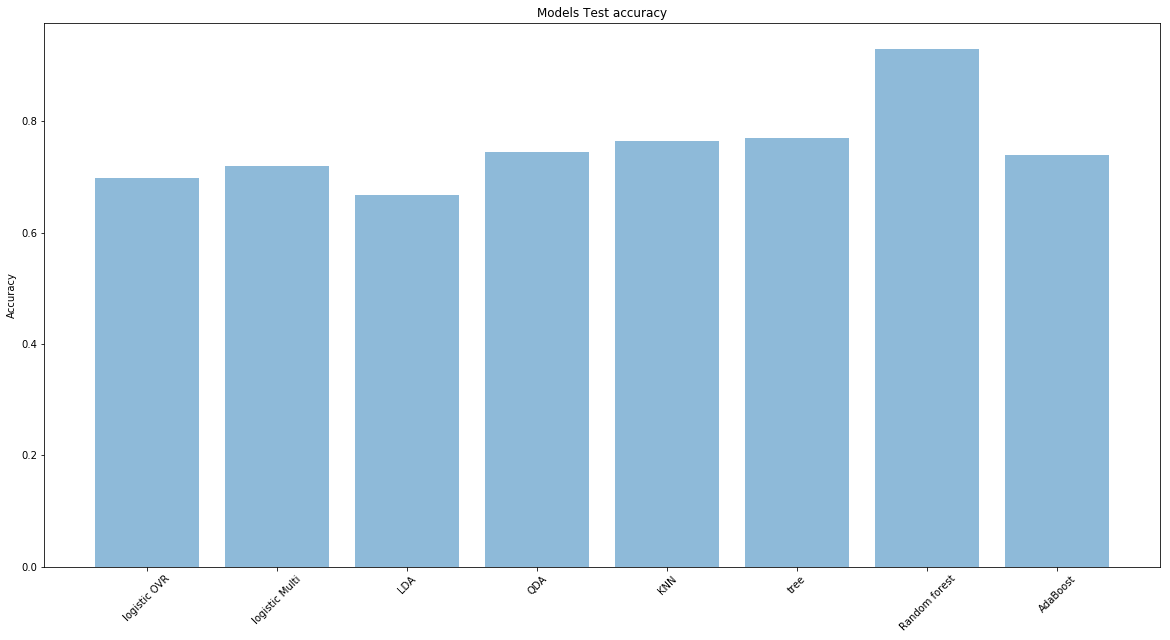

In [20]:
x_pos = np.arange(len(models_name))
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.bar(x_pos, test_score, align='center', alpha=0.5)
ax.set_xticklabels(models_name, size=10)
ax.set_xticks(x_pos)
ax.set_ylabel('Accuracy')
ax.set_title('Models Test accuracy')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45);

In [19]:
logistic_model.coef_

NameError: name 'logistic_model' is not defined

In [ ]:
''' Multiclass Logistic Regression with quadratic terms '''

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

logr_ovr_q = LogisticRegressionCV(Cs=10, cv=5, fit_intercept=True, penalty='l2', refit=True, multi_class='ovr')
logr_ovr_q.fit(X_train_poly, y_train)
y_hat_ovr_train = logr_ovr_q.predict(X_train_poly)

logr_m_q = LogisticRegressionCV(Cs=10, cv=5, fit_intercept=True, penalty='l2', refit=True, multi_class='multinomial')
logr_m_q.fit(X_train_poly, y_train)

print('=== Comparing Accuracy between OvR and Multinomial Logistic Regression with Quadratic Terms ===\n')
print('--- One-vs-Rest Logistic Regression')
print('The accuracy on the training set = {0:6f}'.format(accuracy_score(y_train, logr_ovr_q.predict(X_train_poly))))
print('The accuracy on the test set = {0:6f}\n'.format(accuracy_score(y_test, logr_ovr_q.predict(X_test_poly))))
print('--- Multinomial Logistic Regression')
print('The accuracy on the training set = {0:6f}'.format(accuracy_score(y_train, logr_m_q.predict(X_train_poly))))
print('The accuracy on the test set = {0:6f}'.format(accuracy_score(y_test, logr_m_q.predict(X_test_poly))))

In [ ]:
''' calculate the precision (applicable because we have 2 classes)'''
from sklearn.metrics import classification_report
print(classification_report(y_train, y_hat_ovr_train>0.5))

### Compare with Linear Regression fit to only continuous, with ordinal transformation of response variable

In [ ]:
''' first, identify the order of response variable values '''

# What we did previously: 3 = LMCI, 1 = CN, 2 = EMCI, 0 = AD, 4= SMC
print('original unique response values: ', ADNI2_clean_remove_all_missing_load['DX_bl'].unique())
print('encoded values: ',ADNI2_clean_remove_all_missing_processed['DX_bl'].unique())

# THE TRUE ORDINAL ORDER OF DX should be: CN, SMC, EMCI, LMCI, AD 
# (source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4643840/pdf/nihms705478.pdf)
print('The response value order should really be: 3 = LMCI, 0 = CN, 2 = EMCI, 4 = AD, 1 = SMC')
# So we need to change CN from 1 to 0, AD from 0 to 4, SMC from 4 to 1 in y_train and y_test
# EMCI and LMCI stay the same

print('So we convert y_train and y_test to ordinal values in the next cell.')

In [ ]:
''' make copies the training and test datasets for this linear regression model '''

# train set
X_train_linear_regr = X_train.copy()
# drop the predictor for gender, since this isn't continuous
X_train_linear_regr = X_train_linear_regr.drop(['PTGENDER_Male'], axis =1)
y_train_linear_regr = y_train.copy()

# test set
X_test_linear_regr = X_test.copy()
# drop the predictor for gender
X_test_linear_regr = X_test_linear_regr.drop(['PTGENDER_Male'], axis =1)
y_test_linear_regr = y_test.copy()


''' convert response variable to ordinal ''' 

# convert y_train to ordinal 
for row in y_train_linear_regr:
    # convert CN from 1 to 0
    if row == 1:
        row = 0
    # convert AD from 0 to 4
    if row == 0:
        row = 4
    # convert SMC from 4 to 1
    if row == 4:
        row = 1
        
# convert y_test to ordinal 
for row in y_test_linear_regr:
    # convert CN from 1 to 0
    if row == 1:
        row = 0
    # convert AD from 0 to 4
    if row == 0:
        row = 4
    # convert SMC from 4 to 1
    if row == 4:
        row = 1

In [ ]:
import statsmodels.api as sm
from statsmodels.api import OLS

# add column to house intercept
X_train_linreg_wcons = sm.add_constant(X_train_linear_regr)
X_test_linreg_wcons = sm.add_constant(X_test_linear_regr)

# fit
ols = OLS(endog = y_train_linear_regr, exog = X_train_linreg_wcons).fit()
ols.summary()

In [ ]:
# predictions
y_hat_ols_train = ols.predict(X_train_linreg_wcons)
y_hat_ols_test = ols.predict(X_test_linreg_wcons)

# accuracy
print("ols single predictor accuracy in train = %0.3f" % accuracy_score(y_train_linear_regr, y_hat_ols_train>0.5))
print("ols single predictor accuracy in test = %0.3f\n" % accuracy_score(y_test_linear_regr, y_hat_ols_test>0.5))

# classification report
print('classification report:\n\n', classification_report(y_train, y_hat_ols_train >0.5))